# 8.0.0 Evaluate Final Classifier Model

### Performance Evaluation

The final classifier model was assessed on unseen test data to gauge its real-world applicability and robustness. We got the following results:

**Overall Performance on Test Data:**
- **ROC AUC Score:** 0.5634
- **Precision-Recall AUC:** 0.1989
- **Kolmogorov-Smirnov Statistic:** 0.1011

**Performance Over Time:**
| Month    | ROC AUC Score | PR AUC   | KS       |
|----------|---------------|----------|----------|
| 2023-03  | 0.5607        | 0.2121   | 0.1009   |
| 2023-04  | 0.5666        | 0.1863   | 0.1218   |

**Performance by Loan Count Range:**
| Loan Count Range | ROC AUC Score | PR AUC   | KS       |
|------------------|---------------|----------|----------|
| (-1, 0]          | 0.5013        | 0.1693   | 0.0192   |
| (0, 5]           | 0.5935        | 0.2380   | 0.1808   |
| (5, 300]         | 0.5956        | 0.2202   | 0.1531   |

### SHAP Value Analysis

SHAP values were analyzed to understand the impact of various features on the model's predictions. These values highlight how each feature contributes to pushing the model output from the base value (the output that would be predicted if we did not know any features for the current output) to the actual model output.

**Top Impactful Features (SHAP Values):**
| Feature                                                 | SHAP Value |
|---------------------------------------------------------|------------|
| previous_internal_apps__account_to_application_days     | 0.0986     |
| credit_reports__loans_with_at_least_one_delayed         | 0.0615     |
| credit_reports__credit_limit_median_revolvente          | 0.0534     |
| ...                                                     | ...        |


### Conclusion

The evaluation of the final model shows moderate performance with room for improvement, especially in handling minority class predictions effectively as indicated by the PR AUC scores. The time-wise and loan count-wise performance breakdown provides insights into model stability across different temporal segments and customer segments. The SHAP analysis offers valuable explanations which can help in further tuning and trust-building for model decisions.

Future efforts will focus on enhancing model accuracy and robustness through advanced feature engineering, hyperparameter optimization, and possibly integrating additional data sources to enrich the model's understanding of the applicant's financial behavior.

In [1]:
import pandas as pd
import numpy as np
import pickle
import yaml
import shap 
from pathlib import Path
from sklearn import metrics
from scipy.stats import ks_2samp
from sklearn.metrics import roc_auc_score
from src.utils import calculate_metrics, load_pickle
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
import warnings
warnings.filterwarnings('ignore')

/Users/mfrancys/anaconda3/envs/myenv-credit-risk-machine-learning-pipeline-/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def calculate_metrics_by(df, group_col, target):
    
    monthly_metrics = {}
  
    for month in list(df[group_col].unique()):

        df_filter = df[df[group_col]==month]
        
        y_holdout = df_filter[target]
        preds = df_filter['score']
        
        roc_auc = metrics.roc_auc_score(y_true=y_holdout, y_score=preds)
        pr = metrics.average_precision_score(y_true=y_holdout, y_score=preds)
        ks = ks_2samp(preds[y_holdout == 0], preds[y_holdout == 1])[0]

        metrics_dict = {
            'roc_auc_score': roc_auc,
            'pr_auc': pr,
            'ks': ks,
        }

        monthly_metrics[month] = metrics_dict

    return monthly_metrics

### 1. Data Preparation


In [3]:
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)
    
numeric_features = config["filter_features"]["numerical"]

features = numeric_features
target = config["main"]["target"]
test_data_path = Path.cwd().parent / config["main"]["data_test_path"]

test_df = pd.read_pickle(test_data_path)

model_path = Path.cwd().parent / config["main"]["model_path"]
model = load_pickle(Path.cwd().parent / config["main"]["model_path"])

X_test, Y_test = test_df[features], test_df[target]

test_df["score"] = model.predict_proba(X_test)[:, 1]

In [4]:
bins = pd.IntervalIndex.from_tuples([(-1,0), (0, 5), (5, 10), (10, 20), (20, 30), (30, 300)])
test_df["credit_reports__loans_count_range"] = pd.cut(test_df["credit_reports__loans_count"], bins = bins, right = False, include_lowest=True)
_test_df = test_df.groupby(["credit_reports__loans_count_range"]).agg({"target": ["count", "sum", "mean"]})
_test_df

target               
                                   count  sum      mean
credit_reports__loans_count_range                      
(-1, 0]                             1238  209  0.168821
(0, 5]                               268   38  0.141791
(5, 10]                              325   61  0.187692
(10, 20]                             588  123  0.209184
(20, 30]                             405   74  0.182716
(30, 300]                           1021  145  0.142018

In [5]:
bins = pd.IntervalIndex.from_tuples([(-1,0), (0, 5), (5, 300)])
test_df["credit_reports__loans_count_range_3_labels"] = pd.cut(test_df["credit_reports__loans_count"], bins = bins, right = False, include_lowest=True)
_test_df = test_df.groupby(["credit_reports__loans_count_range_3_labels"]).agg({"target": ["count", "sum", "mean"]})
_test_df

target               
                                            count  sum      mean
credit_reports__loans_count_range_3_labels                      
(-1, 0]                                      1238  209  0.168821
(0, 5]                                        268   38  0.141791
(5, 300]                                     2339  403  0.172296

In [6]:
bins = pd.IntervalIndex.from_tuples([(-1,0), (0, 20)])
test_df["previous_internal_apps__n_bnpl_approved_apps_range"] = pd.cut(test_df["previous_internal_apps__n_bnpl_approved_apps"], bins = bins, right = False, include_lowest=True)
_test_df = test_df.groupby(["previous_internal_apps__n_bnpl_approved_apps_range"]).agg({"target": ["count", "sum", "mean"]})
_test_df

target               
                                                    count  sum      mean
previous_internal_apps__n_bnpl_approved_apps_range                      
(-1, 0]                                              3307  587  0.177502
(0, 20]                                               538   63  0.117100

### 2. Model Results

#### overall

{'roc_auc_score': 0.5634149512459371,
 'pr_auc': 0.1988542886713352,
 'ks': 0.10111713013121464}

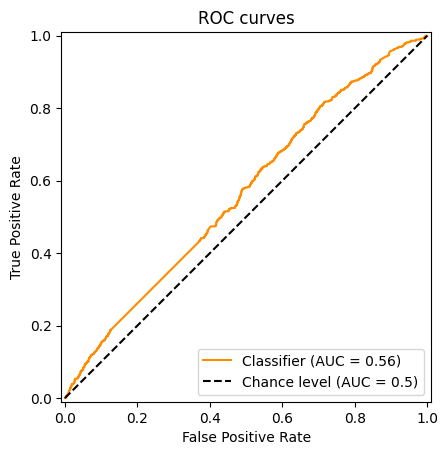

In [7]:
display = RocCurveDisplay.from_predictions(
    Y_test,
    test_df["score"],
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="ROC curves",
)

calculate_metrics(Y_test, test_df["score"])

In [8]:
pd.DataFrame(calculate_metrics_by(test_df, 'loan_origination_datetime_month', target)).T.sort_index()

,roc_auc_score,pr_auc,ks
2023-03,0.560691,0.212087,0.100901
2023-04,0.566589,0.186332,0.121786


In [9]:
pd.DataFrame(calculate_metrics_by(test_df, "credit_reports__loans_count_range", target)).T.sort_index()

,roc_auc_score,pr_auc,ks
"(-1, 0]",0.501265,0.169333,0.019199
"(0, 5]",0.593478,0.238011,0.180778
"(5, 10]",0.580353,0.235799,0.173746
"(10, 20]",0.586957,0.255309,0.177288
"(20, 30]",0.611946,0.251436,0.212460
"(30, 300]",0.580287,0.173420,0.165627


#### by number of loans

In [10]:
pd.DataFrame(calculate_metrics_by(test_df, "credit_reports__loans_count_range_3_labels", target)).T.sort_index()

,roc_auc_score,pr_auc,ks
"(-1, 0]",0.501265,0.169333,0.019199
"(0, 5]",0.593478,0.238011,0.180778
"(5, 300]",0.595612,0.220181,0.153134


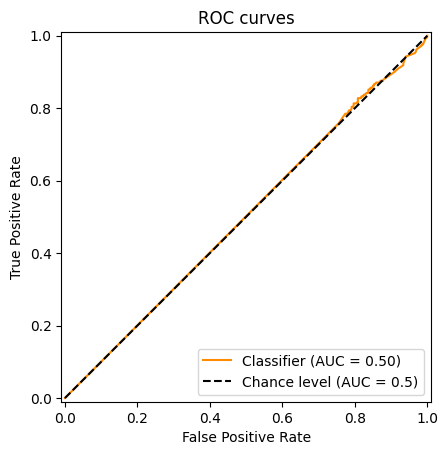

In [11]:
test_df_aux = test_df[test_df["credit_reports__loans_count"]==0]
display = RocCurveDisplay.from_predictions(
    test_df_aux[target],
    test_df_aux["score"],
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="ROC curves",
)

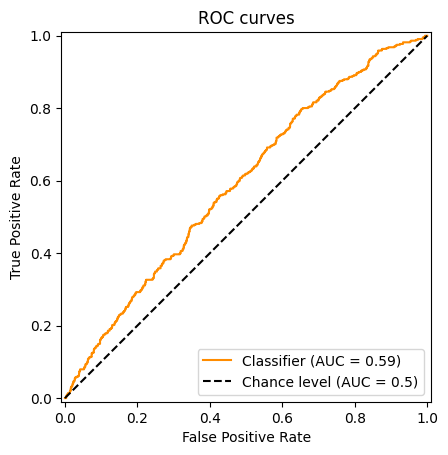

In [12]:
test_df_aux = test_df[test_df["credit_reports__loans_count"]>0]
display = RocCurveDisplay.from_predictions(
    test_df_aux[target],
    test_df_aux["score"],
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="ROC curves",
)

### 3. Shap values 

#### Overall

(3845, 14)


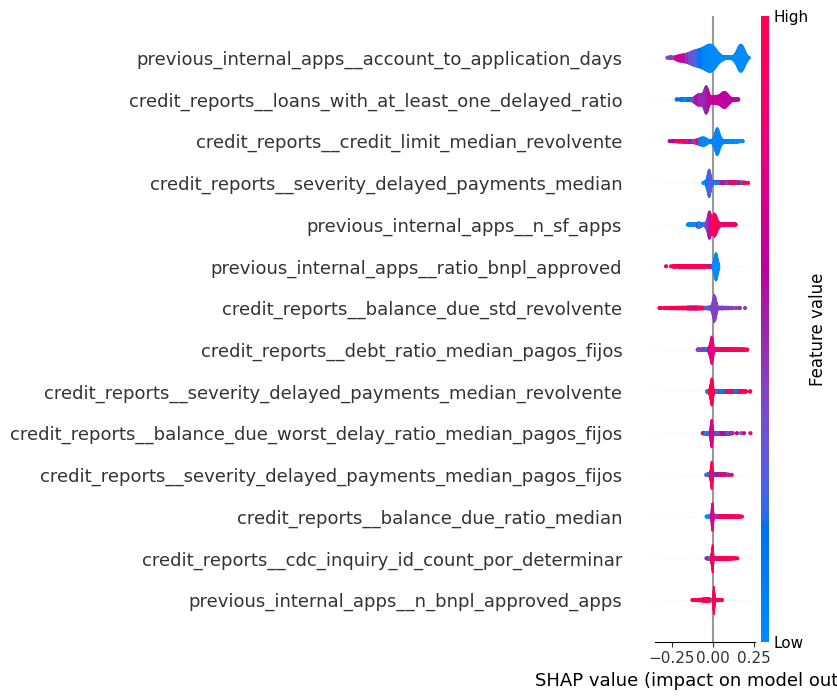

,col_name,shap_value
0,previous_internal_apps__account_to_application...,0.098605
10,credit_reports__loans_with_at_least_one_delaye...,0.061515
8,credit_reports__credit_limit_median_revolvente,0.053365
11,credit_reports__severity_delayed_payments_median,0.036258
2,previous_internal_apps__n_sf_apps,0.036006
3,previous_internal_apps__ratio_bnpl_approved,0.028631
5,credit_reports__balance_due_std_revolvente,0.023330
9,credit_reports__debt_ratio_median_pagos_fijos,0.020097
13,credit_reports__severity_delayed_payments_medi...,0.018294
6,credit_reports__balance_due_worst_delay_ratio_...,0.016788


In [13]:
df_test_filter = test_df
print(df_test_filter[features].shape)
shap_values = shap.TreeExplainer(model).shap_values(df_test_filter[features])
shap.summary_plot(shap_values, df_test_filter[features], plot_type='violin')

feature_names = df_test_filter[features].columns
rf_resultX = pd.DataFrame(shap_values, columns = feature_names)
vals = np.abs(rf_resultX.values).mean(0)
shap_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                  columns=['col_name','shap_value'])
shap_importance.sort_values(by=['shap_value'],
                               ascending=False, inplace=True)
shap_importance.head(60)

#### credit_reports__loans_count equal to 0

(1238, 14)


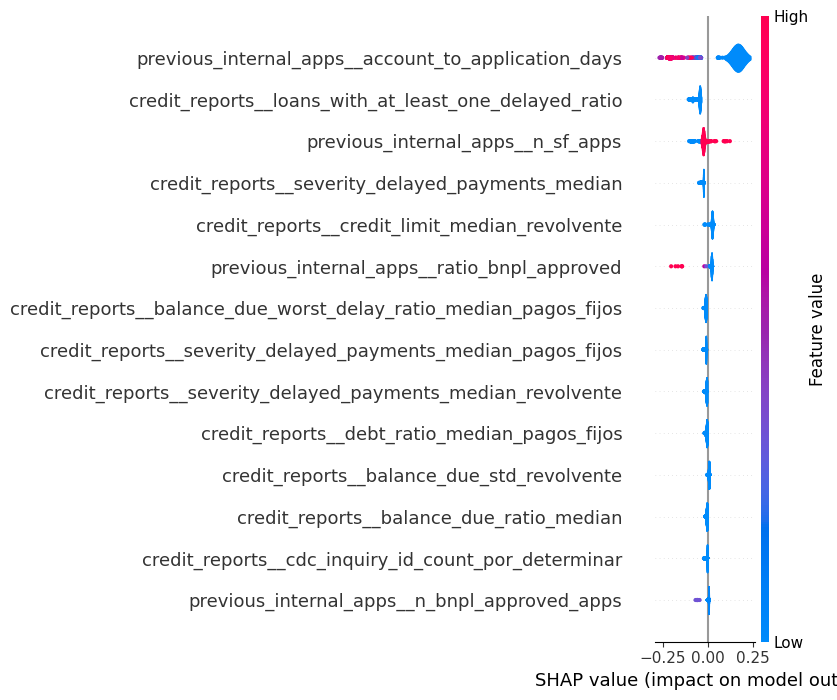

,col_name,shap_value
0,previous_internal_apps__account_to_application...,0.165105
10,credit_reports__loans_with_at_least_one_delaye...,0.053065
2,previous_internal_apps__n_sf_apps,0.033290
11,credit_reports__severity_delayed_payments_median,0.026279
8,credit_reports__credit_limit_median_revolvente,0.023692
3,previous_internal_apps__ratio_bnpl_approved,0.020876
6,credit_reports__balance_due_worst_delay_ratio_...,0.012451
12,credit_reports__severity_delayed_payments_medi...,0.011975
13,credit_reports__severity_delayed_payments_medi...,0.007692
9,credit_reports__debt_ratio_median_pagos_fijos,0.006912


In [14]:
df_test_filter = test_df[test_df["credit_reports__loans_count"]==0]
print(df_test_filter[features].shape)
shap_values = shap.TreeExplainer(model).shap_values(df_test_filter[features])
shap.summary_plot(shap_values, df_test_filter[features], plot_type='violin')

feature_names = df_test_filter[features].columns
rf_resultX = pd.DataFrame(shap_values, columns = feature_names)
vals = np.abs(rf_resultX.values).mean(0)
shap_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                  columns=['col_name','shap_value'])
shap_importance.sort_values(by=['shap_value'],
                               ascending=False, inplace=True)
shap_importance.head(60)
    

#### credit_reports__loans_count higher than 0

(2607, 14)


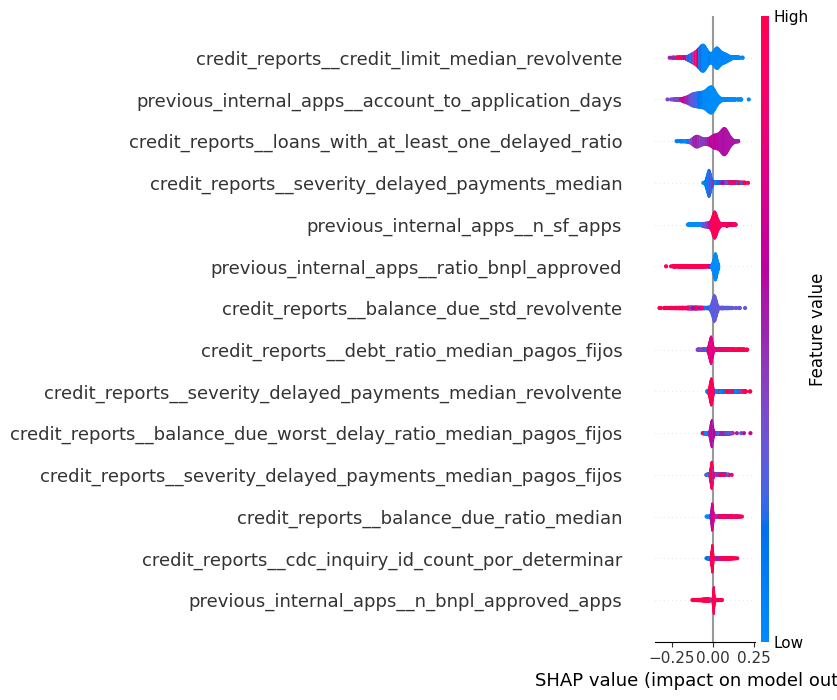

,col_name,shap_value
8,credit_reports__credit_limit_median_revolvente,0.067456
0,previous_internal_apps__account_to_application...,0.067028
10,credit_reports__loans_with_at_least_one_delaye...,0.065526
11,credit_reports__severity_delayed_payments_median,0.040996
2,previous_internal_apps__n_sf_apps,0.037296
3,previous_internal_apps__ratio_bnpl_approved,0.032314
5,credit_reports__balance_due_std_revolvente,0.031355
9,credit_reports__debt_ratio_median_pagos_fijos,0.026358
13,credit_reports__severity_delayed_payments_medi...,0.023329
6,credit_reports__balance_due_worst_delay_ratio_...,0.018847


In [15]:
df_test_filter = test_df[(test_df["credit_reports__loans_count"]>0)]
print(df_test_filter[features].shape)
shap_values = shap.TreeExplainer(model).shap_values(df_test_filter[features])
shap.summary_plot(shap_values, df_test_filter[features], plot_type='violin')
#shap.summary_plot(shap_values[1], X_test[features1], plot_type='bar')

feature_names = df_test_filter[features].columns
rf_resultX = pd.DataFrame(shap_values, columns = feature_names)
vals = np.abs(rf_resultX.values).mean(0)
shap_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                  columns=['col_name','shap_value'])
shap_importance.sort_values(by=['shap_value'],
                               ascending=False, inplace=True)
shap_importance.head(60)
    
